# **<span style="color:Black;">Supervised Notebook</span>**

## **Purpose of Notebook**
Loads, samples, encodes and runs 4 different supervised models and compares the models based on accuracy and experiments with SHAP and LIME for explainabilty

---

## **Contents of notebook**
### **Section 1: Loading, Sampling and Encoding the Dataset**
```python 
- [x] Loading the cleaned datasets
- [x] statified sample the data (uk)
- [x] Prepare, encode, scale, SMOTE,
- [x] Classifcation and Confusion matrix function
```
### **Section 2: Hyperparameter Dictionaries**
### **Section 3: Decision Trees**
### **Section 4: Random Forest**
### **Section 5: XGBoost**
### **Section 6: Logestic Regression**
### **Section 7: Comparision Plots and Table**
### **Section 8: SHAP for Random Forest**
### **Section 9: LIME for Random Forest**

**Import Neccessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support, roc_auc_score)
from imblearn.over_sampling import SMOTENC, SMOTE
import warnings
warnings.filterwarnings('ignore')


## **<span style="color:black;">Section 1: Loading Datasets, sampling and encoding</span>**

**Load Datasets**

In [2]:
"/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded.csv"

UK_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")


print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)


UK shape: (229782, 23)
US shape: (4032, 21)


**Check Column Names**

In [3]:
UK_data = UK_data.drop(columns=['latitude', 'longitude'], errors='ignore')
print("UK Data Columns:", UK_data.columns.tolist())
print("US Data Columns:", US_data.columns.tolist())

UK Data Columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']
US Data Columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']


In [4]:
print(tabulate(UK_data.head(), headers='keys', tablefmt='pretty'))

+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+----------------+---------+--------------------+-----------------+--------------------------+----------------+--------------------+---------------------------------+-------------------------+---------+-----------------+----------------+
|   |   Report ID   | Report Version |   Make   |  Model  | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |      City      |  State  |    Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |    Lighting    |     Crash With     | Highest Injury Severity Alleged |  SV Pre-Crash Movement  | Weather | SV Contact Area |    Country     |
+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+----------------+---------+--------------------+-------

In [5]:
# Display the first 5 rows of UK_data in a pretty table
print(tabulate(US_data.head(), headers='keys', tablefmt='pretty'))

+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+-----------------+--------------------------+----------------------+-------------------------+---------------------------------+-----------------------+-----------+-----------------------+---------+
|   |  Report ID  | Report Version | Make |    Model     | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |     City      | State |   Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |       Lighting       |       Crash With        | Highest Injury Severity Alleged | SV Pre-Crash Movement |  Weather  |    SV Contact Area    | Country |
+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+--

**Statfied Sample for UK data as kernel dies + runtime high**

In [6]:
def stratified_sample(data, sample_frac=0.4, stratify_col='Highest Injury Severity Alleged'):
    """
    Process: Statfied sample on data to ensure severity minority is correctly distributed
    Reference:
    - how to pass in column for splitting: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    - how to split the data for statifying https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat
    - random select sample element(lodash_.) https://www.geeksforgeeks.org/javascript/lodash-_-sample-method/
    """
    if stratify_col not in data.columns:
        possible = data.select_dtypes(include=['object','category']).columns
        stratify_col = possible[0]
    _, sample = train_test_split( # splitting the sampled data
        data,
        test_size=sample_frac, # how much data we want (40%)
        stratify=data[stratify_col],
        random_state=42
    )
    # print results
    print("Original distribution of Severity):")
    print(data[stratify_col].value_counts(normalize=True).head(3))
    print("\nSample distribution of Severity:")
    print(sample[stratify_col].value_counts(normalize=True).head(3))
    return sample

# call function
UK_data= stratified_sample(UK_data, sample_frac=0.4) # 40% sample
print("UK sampled shape:", UK_data.shape)

Original distribution of Severity):
Highest Injury Severity Alleged
Minor       0.774512
Serious     0.210086
Fatality    0.015402
Name: proportion, dtype: float64

Sample distribution of Severity:
Highest Injury Severity Alleged
Minor       0.774515
Serious     0.210090
Fatality    0.015395
Name: proportion, dtype: float64
UK sampled shape: (91913, 21)


In [7]:

def prepare_data(data, target_col = 'Highest Injury Severity Alleged',
                test_size=0.2, val_size=0.1, # 20% test split, 10% validation
                high_card_threshold=20, # if col contains catergory higher than 20
                oversample=True):# to oversample

    """
    Process: encoding the datasets based on cardinality, splitting based on target, scaling, oversampling
    and story within dictionary ready for ml models
    Reference
    - Splititng high/low cardinality: https://forum.enterprisedna.co/t/data-model-split-fact-table-depending-on-cardinality-and-frequent-use/66920
    - dropping: https://www.geeksforgeeks.org/python/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
    - Multiple encoding
    - Label encoding: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    - Frequency encoding:https://letsdatascience.com/frequency-encoding/
        - https://stackoverflow.com/questions/69973615/encoding-high-cardinality-variables
    - Ordinal Encoding: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.
    - scaling: https://amueller.github.io/aml/01-ml-workflow/03-preprocessing.html
    - SMOTE sampling: https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data
        - https://www.geeksforgeeks.org/machine-learning/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
        - https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
    """
    data = data.copy() # create copy
    label_names = None # will store the names of the numbers

    ### Encode targeting the severity column (Label encoding 1,2,3: minor, moderate, severe)
    # find the datatype of severity and if categorical then label encoding it 
    if data[target_col].dtype == 'object' or str(data[target_col].dtype).startswith('category'):
        le = LabelEncoder()  # label encoding
        # make string and then map to number
        data[target_col] = le.fit_transform(data[target_col].astype(str))
        label_names = list(le.classes_)
        print(f"Encoded target '{target_col}' -> Classes: {list(label_names)}")
    else:
        print(f"'{target_col}' is already numeric.")# if already encoded
        label_names = sorted(data[target_col].unique())

    ### Drop ID columns
    drop_cols = ['Report ID', 'Report Version'] 
    data = data.drop(columns=[col for col in drop_cols if col  in data.columns], errors='ignore')
    
    ### Separate data features and target
    X = data.drop(columns=[target_col]) # rest of the cols
    y = data[target_col] # all severity
    
    # Split into high and low cardinality
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() # get categorical cols
    high_card_cols = [col for col in cat_cols if X[col].nunique() > high_card_threshold] # high more than 20
    low_card_cols  = [col for col in cat_cols if X[col].nunique() <= high_card_threshold] # less than 20
    
    ### Frequency encode the  high-cardinality columns
    for col in high_card_cols:
        freq_map = X[col].value_counts().to_dict() # frequency mapping
        X[col] = X[col].map(freq_map)
        print(f"Frequency encoded '{col}' (unique: {len(freq_map)})")
    
    ### Ordinal encode the low-cardinality columns
    if low_card_cols:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X[low_card_cols] = oe.fit_transform(X[low_card_cols])
        print(f"Ordinal encoded columns: {low_card_cols}")
    
    # SStratified Splitting train and testing
    stratify = y if len(np.unique(y)) > 1 else None
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify
    )
    
    # Stratified splitting validation and training
    val_ratio_of_train_val = val_size / (1 - test_size) # 100-20 resplitting so no overlap in test/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_ratio_of_train_val,
        random_state=42, # reproducabilty
        stratify=y_train_val if stratify is not None else None
    )
    
    # IF RESULTS NOT GREAT LETS Oversampling ---------------------------------------------------------------------------
    if oversample:
        print("Performing oversampling on training data...")
        categorical_indices = [X_train.columns.get_loc(col) for col in low_card_cols if col in X_train.columns]
        if categorical_indices:
            smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
            X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)
        else:
            # If no categorical, just use SMOTE
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        print("Resampled class distribution:")
        print(pd.Series(y_train_resampled).value_counts())
        
        X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
        y_train = pd.Series(y_train_resampled)
    
   # Scaling based on mean standard dev ---------------------------------------------------------------------------
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val_scaled   = pd.DataFrame(scaler.transform(X_val),   index=X_val.index,   columns=X_val.columns)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  index=X_test.index,  columns=X_test.columns)
    # print the size of splits
    print("Shapes X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
    print("Class distribution in y_train:") # split for class
    
    return { # store the values in dictionary to use in sach dataset
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'X_train_scaled': X_train_scaled, 'X_val_scaled': X_val_scaled, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'feature_names': X_train.columns.tolist(),
        'scaler': scaler,
        'target_col': target_col,
        'label_names': label_names
    }


In [8]:
prep_uk = prepare_data(UK_data)
print(prep_uk['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Serious']
Frequency encoded 'Make' (unique: 56)
Frequency encoded 'Model' (unique: 518)
Frequency encoded 'Incident Date' (unique: 1826)
Frequency encoded 'Incident Time (24:00)' (unique: 1440)
Frequency encoded 'City' (unique: 4136)
Ordinal encoded columns: ['ADS Equipped?', 'Automation System Engaged?', 'State', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']
Performing oversampling on training data...
Resampled class distribution:
Highest Injury Severity Alleged
1    49831
2    49831
0    49831
Name: count, dtype: int64
Shapes X_train: (149493, 18) X_val: (9192, 18) X_test: (18383, 18)
Class distribution in y_train:
       Make     Model  Model Year  ADS Equipped?  Automation System Engaged?  \
0 -1.530353 -0.906467    0.896739            0.0                         0.0   
1  0.160773  0.518478   -1.642489            0.0  

In [9]:
prep_us = prepare_data(US_data)
print(prep_us['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Moderate', 'No Injuries Reported', 'Serious']
Frequency encoded 'Make' (unique: 54)
Frequency encoded 'Model' (unique: 150)
Frequency encoded 'Incident Date' (unique: 99)
Frequency encoded 'Incident Time (24:00)' (unique: 1310)
Frequency encoded 'City' (unique: 1299)
Frequency encoded 'State' (unique: 51)
Frequency encoded 'SV Contact Area' (unique: 43)
Ordinal encoded columns: ['ADS Equipped?', 'Automation System Engaged?', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'Country']
Performing oversampling on training data...
Resampled class distribution:
Highest Injury Severity Alleged
3    2123
4    2123
1    2123
0    2123
2    2123
Name: count, dtype: int64
Shapes X_train: (10615, 18) X_val: (404, 18) X_test: (807, 18)
Class distribution in y_train:
       Make     Model  Model Year  ADS Equipped?  Automation System Engaged?  \
0  0.801981  0.714173  

**Helper Classfication function for retriving confusion matrix and accuracy**

In [10]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

def evaluate_and_store(name, model, X_train, X_test, y_train, y_test,
                       X_val=None, y_val=None,
                       dataset_label="",  # "US" or "UK"
                       title="",
                       save_folder="/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/<Jupiter Notebooks>/model_evaluation/"):
    """ 
    Process: for the testing/validation set find accuracy, precision, recall, f1 score, and classification report and confusion matrices giving dict of all the values 
        Reference: 
    - How to split and find scores: https://scikit-learn.org/stable/modules/model_evaluation.html 
    - Finding accuracy: https://stackoverflow.com/questions/76488406/finding-the-accuracy-of-the-train-and-test-model 
    - Fidning classfication report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html 
    - Confusion Matrcies: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
    """
    os.makedirs(save_folder, exist_ok=True)
    suffix = f"_{dataset_label}" if dataset_label else ""
    
    # Predict train and test
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    # Training/test metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average='weighted', zero_division=0
    )
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )
    
    metrics = {
        'train_accuracy': train_acc, 'test_accuracy': test_acc,
        'train_precision': train_prec, 'test_precision': test_prec,
        'train_recall': train_rec, 'test_recall': test_rec,
        'train_f1': train_f1, 'test_f1': test_f1,
        'model': model
    }
    
    # Test confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name}{suffix} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    test_path = os.path.join(save_folder, f"{name}{suffix}_test_cm.png")
    plt.savefig(test_path)
    plt.close()
    
    # Save test classification report
    test_report = classification_report(y_test, y_test_pred, zero_division=0)
    report_test_path = os.path.join(save_folder, f"{name}{suffix}_test_report.txt")
    with open(report_test_path, "w") as f:
        f.write(test_report)
    
    # Validation (if provided)
    if X_val is not None and y_val is not None:
        y_val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
            y_val, y_val_pred, average='weighted', zero_division=0
        )
        metrics.update({
            'val_accuracy': val_acc, 'val_precision': val_prec,
            'val_recall': val_rec, 'val_f1': val_f1,
        })
        
        cm_val = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
        plt.title(f"{name}{suffix} - Validation Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        val_path = os.path.join(save_folder, f"{title}{suffix}_val_cm.png")
        plt.savefig(val_path)
        plt.close()
        
        # Save validation classification report
        val_report = classification_report(y_val, y_val_pred, zero_division=0)
        report_val_path = os.path.join(save_folder, f"{name}{suffix}_val_report.txt")
        with open(report_val_path, "w") as f:
            f.write(val_report)
    
    # Print results
    print(f"{name}{suffix} - Test accuracy: {test_acc:.4f}")
    print("Classification report (test):\n", test_report)
    
    if X_val is not None and y_val is not None:
        print(f"{name}{suffix} - Validation accuracy: {val_acc:.4f}")
        print("Classification report (validation):\n", val_report)
    
    return metrics




## **<span style="color:black;">Section 2: Hyperparameter Dictionaries</span>**

**Nested Dictionaries to store all the hyperparameters**

In [11]:
# defining the keys and the values for the hyperparametets (nested dictionaries)
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.0, 0.1, 0.5, 0.9]  # only used with elasticnet; saga supports it
    }
}
# storing the results of best paramters when running
results_store_uk = {}  # empty dict to collect UK model results
results_store_us = {}  # empty dict to collect UK model results


## **<span style="color:black;">Section 3: Decision Trees</span>**


In [12]:
def run_dt_workflow(prep,country,title):
    """
    Process: Running model, tuning, evaluating and training it with decision tree classifier
    Reference:
    - calling the dictionary parameters: https://www.w3schools.com/python/python_dictionaries_nested.asp
    - decision tree: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - randommised search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    """

    dt = DecisionTreeClassifier(random_state=42)
    dt_search = RandomizedSearchCV( # random search to speed up
        dt,
        param_grids['Decision Tree'],
        n_iter=5,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    # apply the best hyperparamters 
    dt_search.fit(prep['X_train'], prep['y_train'])
    print("Best DT params:", dt_search.best_params_)
    best_dt = dt_search.best_estimator_ # stores best para to run 

    dt_metrics = evaluate_and_store(
        'Decision Tree',
        best_dt, # best param
        # run for train and test
        prep['X_train'], prep['X_test'], prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val'), 
        dataset_label= country,
        title = 'Decision Tree'
    )
    return dt_metrics


In [13]:
# For US data
results_store_us['Decision Tree'] = run_dt_workflow(prep_us, country = "US",title ='Decision Tree',)

Best DT params: {'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}
Decision Tree_US - Test accuracy: 0.7051
Classification report (test):
               precision    recall  f1-score   support

           0       0.54      0.65      0.59        95
           1       0.24      0.37      0.29        60
           2       0.12      0.17      0.14        12
           3       0.88      0.77      0.82       607
           4       0.31      0.48      0.38        33

    accuracy                           0.71       807
   macro avg       0.42      0.49      0.44       807
weighted avg       0.76      0.71      0.73       807

Decision Tree_US - Validation accuracy: 0.7129
Classification report (validation):
               precision    recall  f1-score   support

           0       0.52      0.65      0.57        48
           1       0.28      0.47      0.35        30
           2       0.10      0.17      0.12         6
           3       0.91      0.78  

In [14]:
# For US data
results_store_uk['Decision Tree'] = run_dt_workflow(prep_uk,country = "UK",title="Decision Tree")

Best DT params: {'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}
Decision Tree_UK - Test accuracy: 0.5762
Classification report (test):
               precision    recall  f1-score   support

           0       0.04      0.25      0.07       283
           1       0.79      0.67      0.73     14238
           2       0.22      0.25      0.24      3862

    accuracy                           0.58     18383
   macro avg       0.35      0.39      0.34     18383
weighted avg       0.66      0.58      0.61     18383

Decision Tree_UK - Validation accuracy: 0.5765
Classification report (validation):
               precision    recall  f1-score   support

           0       0.04      0.26      0.07       142
           1       0.78      0.68      0.73      7119
           2       0.21      0.23      0.22      1931

    accuracy                           0.58      9192
   macro avg       0.34      0.39      0.34      9192
weighted avg       0.65      0.58 

## **<span style="color:black;">Section 4: Random Forest</span>**

In [15]:
def run_rf_workflow(prep,country,title):
    """
    Process: running random forest classifier with best parameters
    references:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    - https://www.geeksforgeeks.org/dsa/random-forest-classifier-using-scikit-learn/
    - https://stackoverflow.com/questions/28263685/value-error-in-scikit-learn-random-forest-fit-method
    """
    rf = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        rf,
        param_grids['Random Forest'],  # Make sure this param grid is defined for RF
        n_iter=5,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    rf_search.fit(prep['X_train'], prep['y_train'])
    print("Best RF params:", rf_search.best_params_)
    best_rf = rf_search.best_estimator_

    rf_metrics = evaluate_and_store(
        'Random Forest',
        best_rf,
        prep['X_train'], prep['X_test'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val'),  # include validation data,
        dataset_label = country,
        title = 'Random Forest',
    )
    return rf_metrics


In [16]:
# for US data
results_store_us['Random Forest'] = run_rf_workflow(prep_us, country = "US",title='Random Forest')  # for US data


Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Random Forest_US - Test accuracy: 0.7993
Classification report (test):
               precision    recall  f1-score   support

           0       0.62      0.84      0.71        95
           1       0.39      0.38      0.39        60
           2       0.60      0.25      0.35        12
           3       0.89      0.87      0.88       607
           4       0.57      0.24      0.34        33

    accuracy                           0.80       807
   macro avg       0.61      0.52      0.53       807
weighted avg       0.80      0.80      0.79       807

Random Forest_US - Validation accuracy: 0.8069
Classification report (validation):
               precision    recall  f1-score   support

           0       0.60      0.73      0.66        48
           1       0.52      0.53      0.52        30
           2       0.50      0.17      0.25         6
          

In [17]:
# for UK data
results_store_uk['Random Forest'] =  run_rf_workflow(prep_uk,country = "UK",title="Random Forest")  # for UK data


Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Random Forest_UK - Test accuracy: 0.6925
Classification report (test):
               precision    recall  f1-score   support

           0       0.04      0.04      0.04       283
           1       0.78      0.85      0.81     14238
           2       0.24      0.16      0.19      3862

    accuracy                           0.69     18383
   macro avg       0.35      0.35      0.35     18383
weighted avg       0.66      0.69      0.67     18383

Random Forest_UK - Validation accuracy: 0.6972
Classification report (validation):
               precision    recall  f1-score   support

           0       0.03      0.04      0.03       142
           1       0.78      0.86      0.82      7119
           2       0.25      0.16      0.19      1931

    accuracy                           0.70      9192
   macro avg       0.35      0.35      0.35      9192
weighted 

## **<span style="color:black;">Section 5: XGBoost</span>**

In [18]:

def run_xgb_workflow(prep,country,title):
    """
    Process: running XGBoost classifier with best parameters
    references:
    - https://xgboosting.com/how-to-use-xgboost-xgbclassifier/
    - https://www.kaggle.com/code/palanjali007/xgbclassifier
    - logloss: binary classification https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/#:~:text=Stats%2Ddriven%20EDA-,What%20is%20Log%20Loss%3F,predicted%20probabilities%20and%20actual%20values.
    """
    xgb = XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_search = RandomizedSearchCV(
        xgb,
        param_grids['XGBoost'],
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
    )
    xgb_search.fit(prep['X_train'], prep['y_train'])
    print("Best XGB params:", xgb_search.best_params_)
    best_xgb = xgb_search.best_estimator_

    xgb_metrics = evaluate_and_store(
        'XGBoost',
        best_xgb,
        prep['X_train'], prep['X_test'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val'),  # pass validation set here
        dataset_label = country,
        title =  'XGBoost'
    )
    return xgb_metrics


In [19]:
results_store_us['XGBoost'] =  run_xgb_workflow(prep_us ,country = "US",title= 'XGBoost')  # for US data


Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
XGBoost_US - Test accuracy: 0.8178
Classification report (test):
               precision    recall  f1-score   support

           0       0.69      0.85      0.76        95
           1       0.36      0.35      0.36        60
           2       0.50      0.25      0.33        12
           3       0.89      0.89      0.89       607
           4       0.63      0.36      0.46        33

    accuracy                           0.82       807
   macro avg       0.62      0.54      0.56       807
weighted avg       0.81      0.82      0.81       807

XGBoost_US - Validation accuracy: 0.8119
Classification report (validation):
               precision    recall  f1-score   support

           0       0.62      0.69      0.65        48
           1       0.50      0.50      0.50        30
           2       0.33      0.33      0.33         6
           3       0.90      0

In [20]:
results_store_uk['XGBoost'] = run_xgb_workflow(prep_uk,country = "UK", title='XGBoost')  # for UK data

Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
XGBoost_UK - Test accuracy: 0.6578
Classification report (test):
               precision    recall  f1-score   support

           0       0.04      0.14      0.06       283
           1       0.79      0.80      0.79     14238
           2       0.24      0.19      0.21      3862

    accuracy                           0.66     18383
   macro avg       0.36      0.38      0.36     18383
weighted avg       0.66      0.66      0.66     18383

XGBoost_UK - Validation accuracy: 0.6555
Classification report (validation):
               precision    recall  f1-score   support

           0       0.04      0.16      0.07       142
           1       0.79      0.80      0.79      7119
           2       0.23      0.17      0.20      1931

    accuracy                           0.66      9192
   macro avg       0.35      0.38      0.35      9192
weighted avg       0.66      

## **<span style="color:black;">Section 6: Logestic Regression </span>**

In [21]:
def run_lr_workflow(prep,country,title):
    """
    Process: running logestic regression classifier with best parameters
    references:
    - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - https://www.datacamp.com/tutorial/understanding-logistic-regression-python

    """
    lr = LogisticRegression(random_state=42, max_iter=2000)
    lr_search = RandomizedSearchCV(
        lr,
        param_grids['Logistic Regression'],
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    lr_search.fit(prep['X_train_scaled'], prep['y_train'])

    print("Best LR params:", lr_search.best_params_)
    best_lr = lr_search.best_estimator_

    lr_metrics = evaluate_and_store(
        'Logistic Regression',
        best_lr,
        prep['X_train_scaled'], prep['X_test_scaled'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val_scaled'), y_val=prep.get('y_val'),  # include validation if available
        dataset_label = country, 
        title = 'Logistic Regression'
    )
    return lr_metrics


In [22]:
results_store_uk['Logistic Regression'] = run_lr_workflow(prep_uk,country = "UK", title ='Logistic Regression')



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

Best LR params: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 0.01}
Logistic Regression_UK - Test accuracy: 0.4615
Classification report (test):
               precision    recall  f1-score   support

           0       0.03      0.38      0.06       283
           1       0.79      0.50      0.61     14238
           2       0.21      0.32      0.25      3862

    accuracy                           0.46     18383
   macro avg       0.34      0.40      0.31     18383
weighted avg       0.66      0.46      0.53     18383

Logistic Regression_UK - Validation accuracy: 0.4532
Classification report (validation):
               precision    recall  f1-score   support

           0       0.04      0.44      0.07       142
           1       0.79      0.49      0.60      7119
           2       0.20      0.31      0.25      1931

    accuracy                           0.45      9192
   macro avg       0.34      0.41      0.31      9192
weighted avg       0.65      0.45    

In [23]:
results_store_us['Logistic Regression'] = run_lr_workflow(prep_us,country = "US",title = 'Logistic Regression')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

Best LR params: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 1}
Logistic Regression_US - Test accuracy: 0.4758
Classification report (test):
               precision    recall  f1-score   support

           0       0.37      0.53      0.43        95
           1       0.19      0.40      0.26        60
           2       0.03      0.33      0.06        12
           3       0.88      0.48      0.62       607
           4       0.15      0.39      0.21        33

    accuracy                           0.48       807
   macro avg       0.32      0.43      0.32       807
weighted avg       0.73      0.48      0.55       807

Logistic Regression_US - Validation accuracy: 0.4901
Classification report (validation):
               precision    recall  f1-score   support

           0       0.43      0.54      0.48        48
           1       0.22      0.33      0.26        30
           2       0.02      0.17      0.03         6
           3       0.83      0.51      0.63      

## **<span style="color:black;">Section 7: Accuracy Comparison</span>**

In [24]:
def summarize_and_plot_results(results_store, dataset_label=''):
    """
    Process: Outputs a nicely formatted table with the results from the nested results 
    dictionary
    """
    summary_rows = []
    for name, m in results_store.items():
        row = {
            'Model': name,
            'Train Accuracy': m['train_accuracy'],
            'Test Accuracy': m['test_accuracy'],
            'Test Precision': m['test_precision'],
            'Test Recall': m['test_recall'],
            'Test F1': m['test_f1'],
            'Overfit (train-test)': m['train_accuracy'] - m['test_accuracy']
        }
        # Add validation metrics if available
        if 'val_accuracy' in m:
            row.update({
                'Val Accuracy': m['val_accuracy'],
                'Val Precision': m.get('val_precision', None),
                'Val Recall': m.get('val_recall', None),
                'Val F1': m.get('val_f1', None)
            })
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows).sort_values('Test Accuracy', ascending=False)
    print(f"Summary for {dataset_label} dataset:") # print the summary table
    display(summary_df)

    # plot the overall accuracy for us and uk datasets
    plt.figure(figsize=(8, 4))
    sns.set_style("whitegrid")  # adds a grey grid background
    sns.barplot(x='Model', y='Test Accuracy', data=summary_df, palette='pastel')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.title(f"Model test accuracy comparison ({dataset_label})")
    plt.tight_layout()
    plt.show()
    return summary_df



Summary for UK dataset:


,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,Overfit (train-test),Val Accuracy,Val Precision,Val Recall,Val F1
1,Random Forest,1.000000,0.692488,0.655714,0.692488,0.671301,0.307512,0.697237,0.658759,0.697237,0.674894
2,XGBoost,0.761634,0.657782,0.661590,0.657782,0.658515,0.103853,0.655461,0.657409,0.655461,0.655052
0,Decision Tree,0.660439,0.576239,0.659532,0.576239,0.612586,0.084200,0.576480,0.650888,0.576480,0.609371
3,Logistic Regression,0.547577,0.461513,0.657421,0.461513,0.529942,0.086064,0.453220,0.651152,0.453220,0.521076


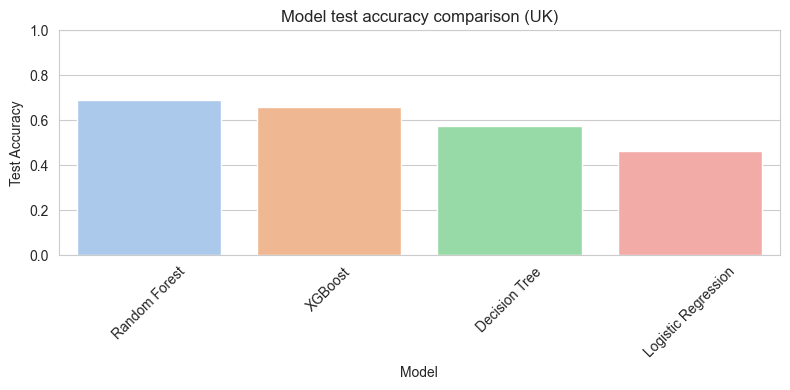

In [25]:
summary_uk = summarize_and_plot_results(results_store_uk, dataset_label='UK')


Summary for US dataset:


,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,Overfit (train-test),Val Accuracy,Val Precision,Val Recall,Val F1
2,XGBoost,0.990579,0.817844,0.814542,0.817844,0.813112,0.172736,0.811881,0.807892,0.811881,0.809009
1,Random Forest,0.999906,0.799257,0.800496,0.799257,0.793978,0.200649,0.806931,0.801442,0.806931,0.801425
0,Decision Tree,0.851060,0.705081,0.755273,0.705081,0.725135,0.145979,0.712871,0.778821,0.712871,0.738494
3,Logistic Regression,0.574282,0.475836,0.728243,0.475836,0.549553,0.098445,0.490099,0.696119,0.490099,0.559642


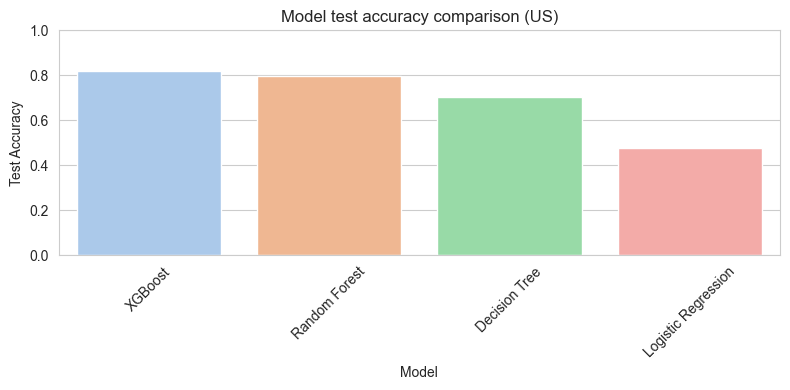

In [26]:
summary_us = summarize_and_plot_results(results_store_us, dataset_label='US')


## **<span style="color:black;">Section 8: SHAP for Random Forest</span>**


In [27]:


def run_shap(results_store, prep, model_name, dataset_label='', save_dir='shap_plots'):
    """
    Generate and save SHAP summary plots for any supported model type.
    
    Parameters:
    - results_store: dict containing trained models
    - prep: dict with preprocessed data, must include 'X_test' and 'feature_names'
    - model_name: str, key in results_store for the model you want to explain
    - dataset_label: optional label for printing
    - save_dir: directory where plots will be saved
    https://github.com/shap/shap/issues/1906
    """
    model = results_store[model_name]['model']
    Xs = prep['X_test'].iloc[:200]  # Limit for speed
    feature_names = prep.get('feature_names', Xs.columns.tolist())

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Choose explainer based on model type
    if hasattr(model, 'predict_proba'):  # common for classifiers
        try:
            explainer = shap.TreeExplainer(model)
        except:
            try:
                explainer = shap.LinearExplainer(model, Xs)
            except:
                explainer = shap.KernelExplainer(model.predict, Xs.sample(50))
    else:
        try:
            explainer = shap.TreeExplainer(model)
        except:
            explainer = shap.KernelExplainer(model.predict, Xs.sample(50))

    shap_values = explainer.shap_values(Xs)

    print(f"SHAP summary plots for {model_name} on {dataset_label} dataset:")

    # Regular summary plot
    plt.figure()
    shap.summary_plot(shap_values, Xs, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name}_summary_{dataset_label}.png"), dpi=300)
    plt.show()
    plt.close()

    # Bar summary plot
    plt.figure()
    shap.summary_plot(shap_values, Xs, plot_type="bar", feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{model_name}_bar_{dataset_label}.png"), dpi=300)
    plt.show()
    plt.close()

SHAP summary plots for Logistic Regression on US dataset:


<Figure size 640x480 with 0 Axes>

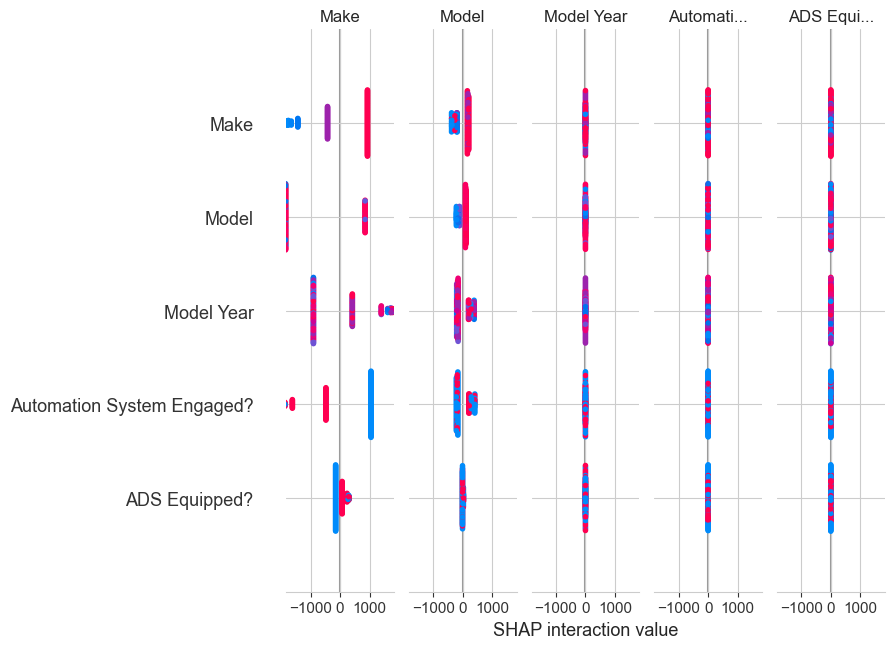

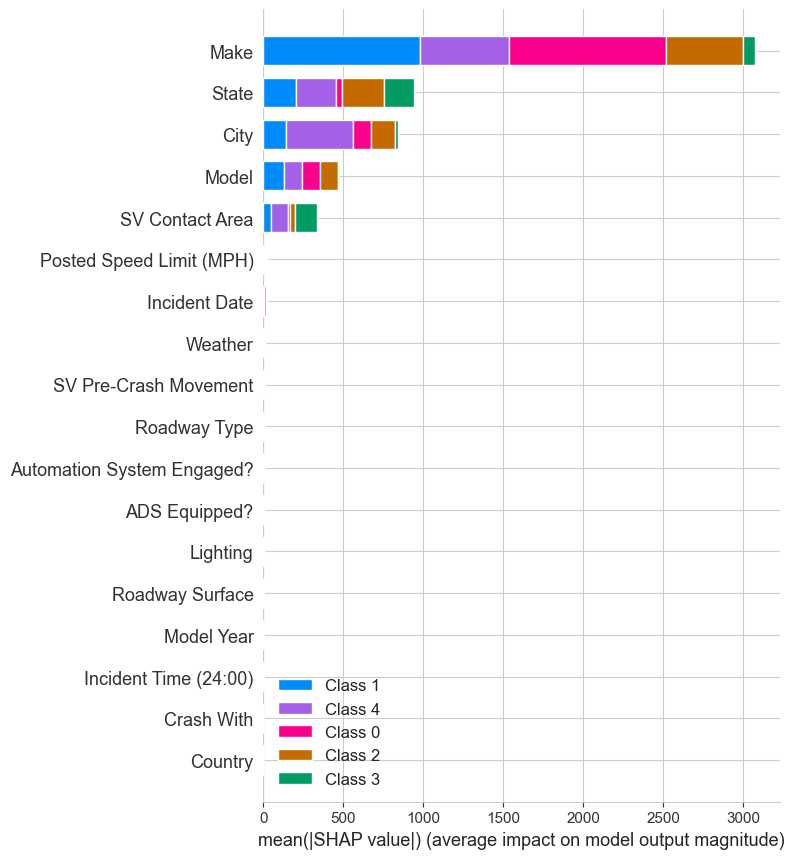

In [29]:
# Run the function
run_shap(results_store_us, prep_us, model_name='Logistic Regression', dataset_label='US')


SHAP summary plots for Logistic Regression on UK dataset:


<Figure size 640x480 with 0 Axes>

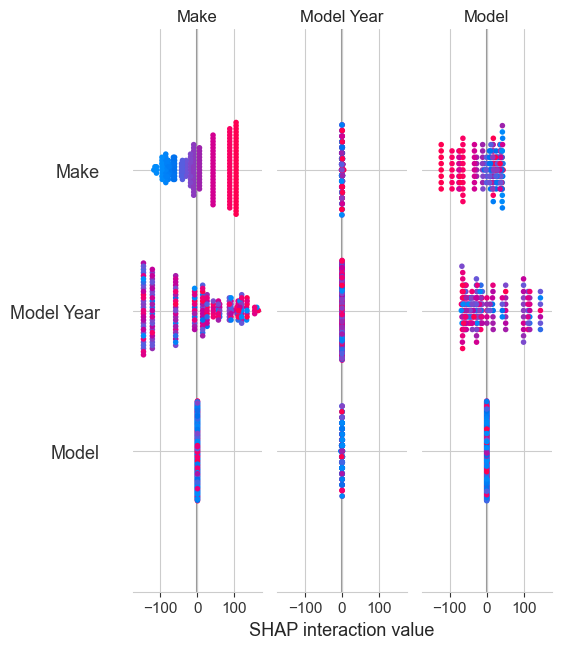

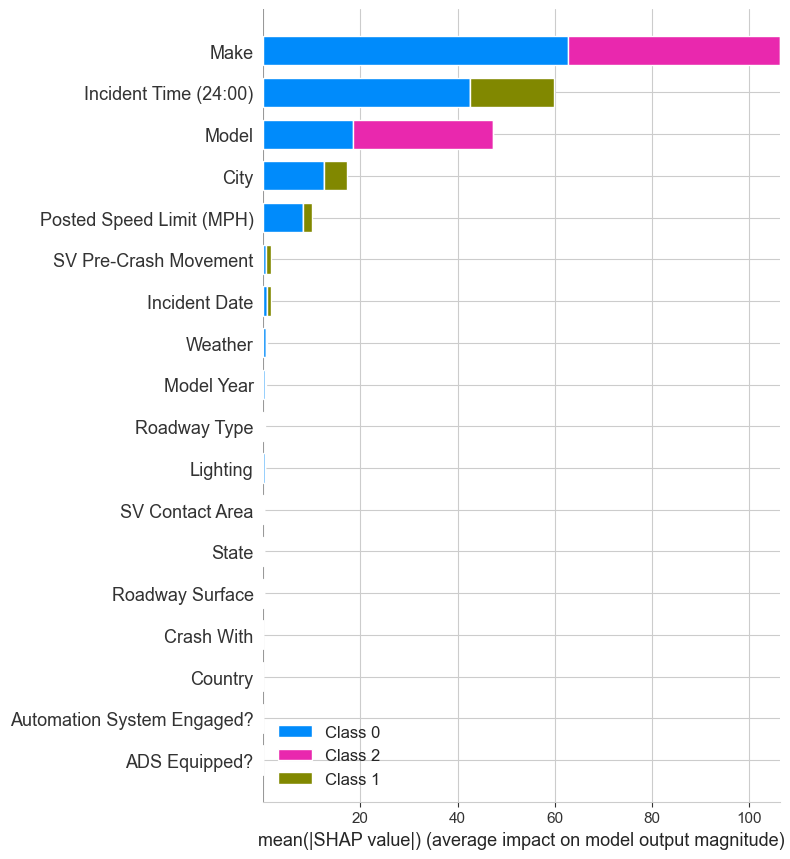

In [30]:
run_shap(results_store_uk, prep_uk, model_name='Logistic Regression', dataset_label='UK')

SHAP summary plots for Random Forest on UK dataset:


<Figure size 640x480 with 0 Axes>

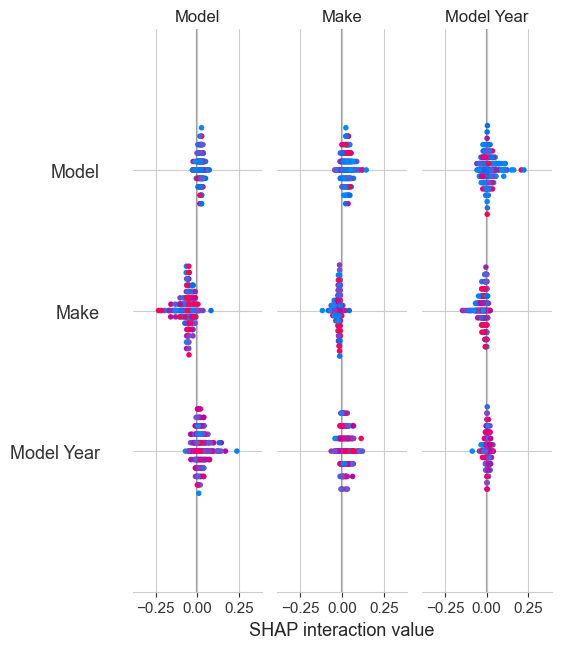

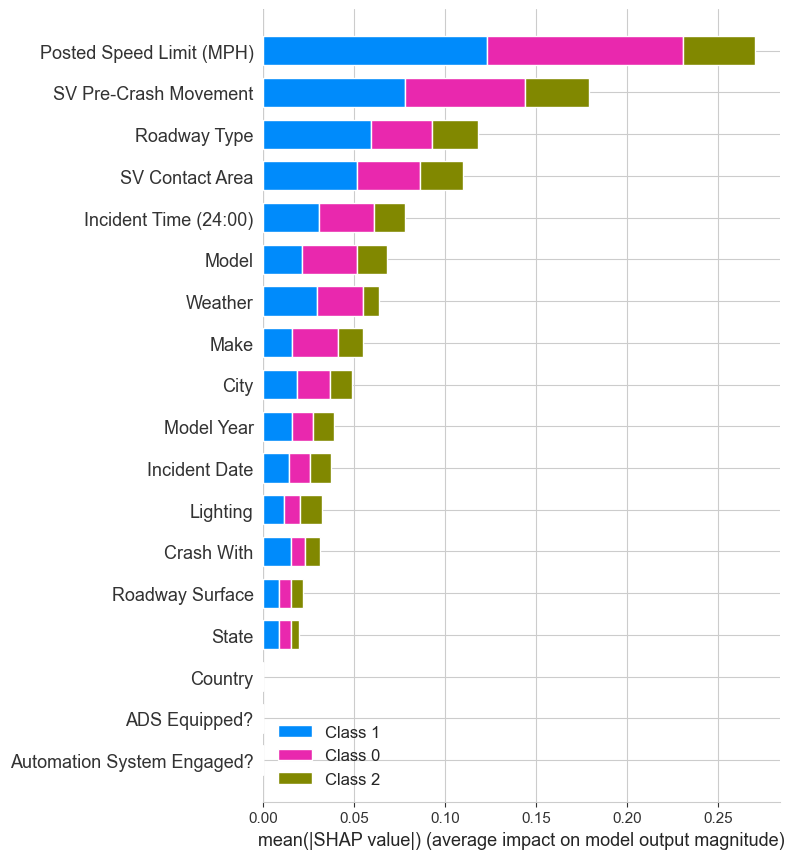

In [31]:

run_shap(results_store_uk, prep_uk, model_name='Random Forest', dataset_label='UK')

In [ ]:

run_shap(results_store_us, prep_us, model_name='Random Forest', dataset_label='US')




In [ ]:

run_shap(results_store_uk, prep_uk, model_name='Decision Tree', dataset_label='UK')

SHAP summary plots for Decision Tree on UK dataset:


<Figure size 640x480 with 0 Axes>

In [ ]:

run_shap(results_store_us, prep_us, model_name='Decision Tree', dataset_label='US')

SHAP summary plots for Decision Tree on US dataset:


<Figure size 640x480 with 0 Axes>

In [ ]:
run_shap(results_store_us, prep_us, model_name='XGBoost', dataset_label='US')

SHAP summary plots for XGBoost on US dataset:


<Figure size 640x480 with 0 Axes>

In [ ]:
run_shap(results_store_uk, prep_uk, model_name='XGBoost', dataset_label='UK')

SHAP summary plots for XGBoost on UK dataset:


<Figure size 640x480 with 0 Axes>

## **<span style="color:black;">Section 9: LIME for Random Forest</span>**


In [ ]:
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import os

def lime_explain(results_store, prep, model_name, dataset_label='', instance_idx=0, save_dir='lime_explanations'):
    """
    Generate and save LIME explanation as PNG for a specific model and instance.

    Parameters:
    - results_store: dict containing trained models
    - prep: dict with preprocessed data
    - model_name: str, key in results_store for the model
    - dataset_label: str, label for dataset
    - instance_idx: int, index of test instance
    - save_dir: str, folder to save output PNG
        - https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-lime
    - https://stackoverflow.com/questions/70984947/efficient-way-to-generate-lime-explanations-for-full-dataset
    """
    try:
        model = results_store[model_name]['model']

        # Determine mode (classification vs regression)
        mode = 'classification' if hasattr(model, 'predict_proba') else 'regression'

        # Determine class names if classification
        if mode == 'classification':
            if prep.get('label_encoder') is not None:
                class_names = list(prep['label_encoder'].classes_)
            else:
                class_names = [str(c) for c in sorted(prep['y_train'].unique())]
        else:
            class_names = None

        # Create save directory
        os.makedirs(save_dir, exist_ok=True)

        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            prep['X_train'].values,
            feature_names=prep['feature_names'],
            class_names=class_names,
            discretize_continuous=True,
            mode=mode
        )

        # Select instance to explain
        instance = prep['X_test'].iloc[instance_idx].values

        # Pick prediction function depending on mode
        predict_fn = model.predict_proba if mode == 'classification' else model.predict

        # Generate explanation
        explanation = explainer.explain_instance(instance, predict_fn, num_features=10)

        # Save PNG static version
        fig = explanation.as_pyplot_figure()
        file_name = f"LIME_{model_name}_{dataset_label}_idx{instance_idx}.png"
        file_path = os.path.join(save_dir, file_name)
        fig.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)

        print(f"Saved LIME PNG to: {file_path}")

    except Exception as e:
        print(f"LIME error for {dataset_label} dataset:", e)


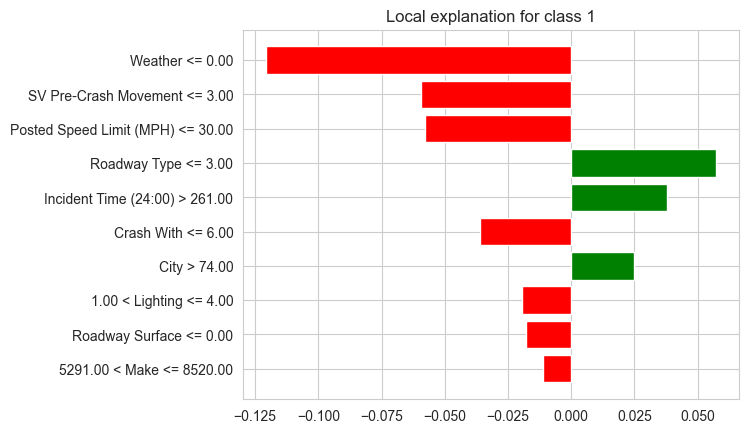

Saved LIME PNG to: lime_explanations/LIME_Random Forest_UK_idx5.png


In [ ]:

lime_explain(results_store_uk, prep_uk, model_name='Random Forest', dataset_label='UK', instance_idx=5)




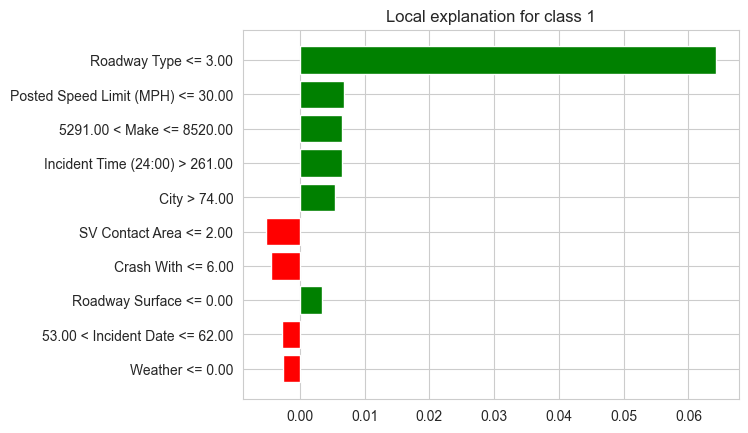

Saved LIME PNG to: lime_explanations/LIME_Logistic Regression_UK_idx5.png


In [ ]:
lime_explain(results_store_uk, prep_uk, model_name='Logistic Regression', dataset_label='UK', instance_idx=5)


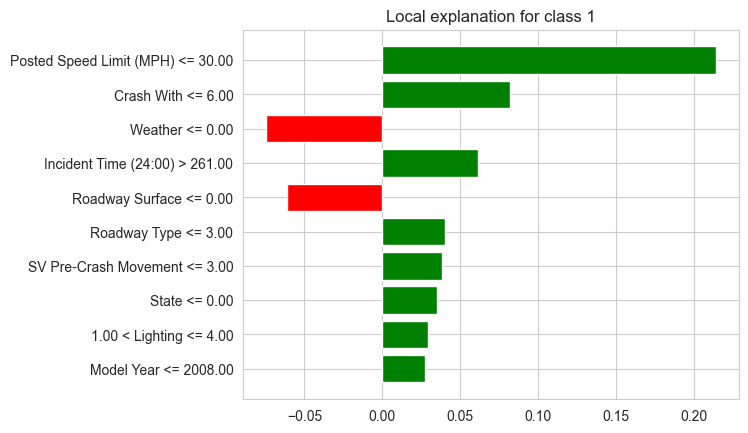

Saved LIME PNG to: lime_explanations/LIME_XGBoost_UK_idx5.png


In [ ]:
lime_explain(results_store_uk, prep_uk, model_name='XGBoost', dataset_label='UK', instance_idx=5)


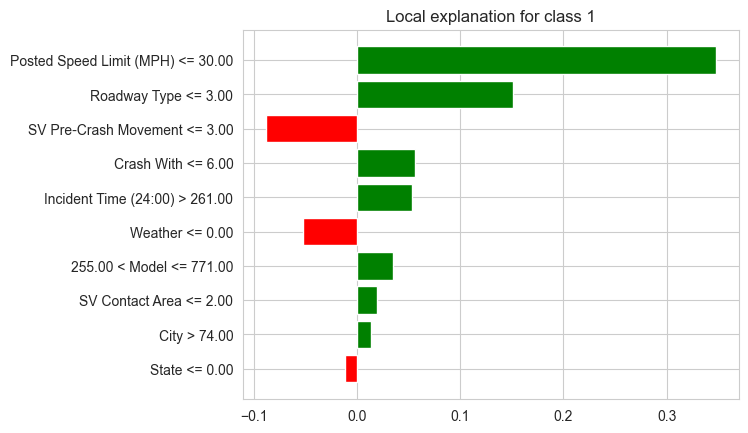

Saved LIME PNG to: lime_explanations/LIME_Decision Tree_UK_idx5.png


In [ ]:
lime_explain(results_store_uk, prep_uk, model_name='Decision Tree', dataset_label='UK', instance_idx=5)


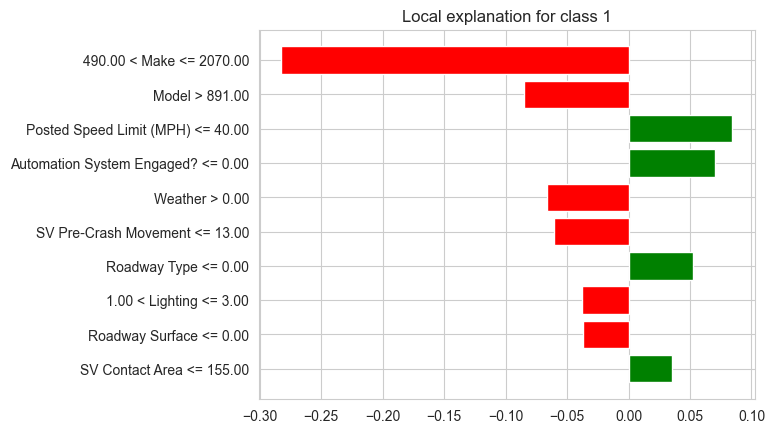

Saved LIME PNG to: lime_explanations/LIME_XGBoost_US_idx5.png


In [ ]:
lime_explain(results_store_us, prep_us, model_name='XGBoost', dataset_label='US', instance_idx=5)


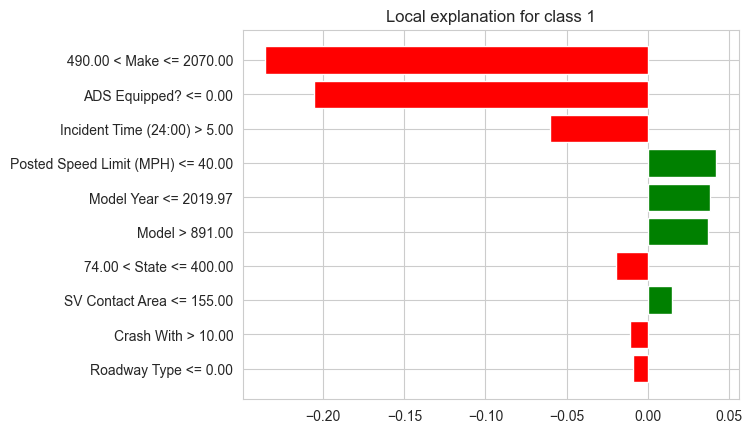

Saved LIME PNG to: lime_explanations/LIME_Decision Tree_US_idx5.png


In [ ]:
lime_explain(results_store_us, prep_us, model_name='Decision Tree', dataset_label='US', instance_idx=5)

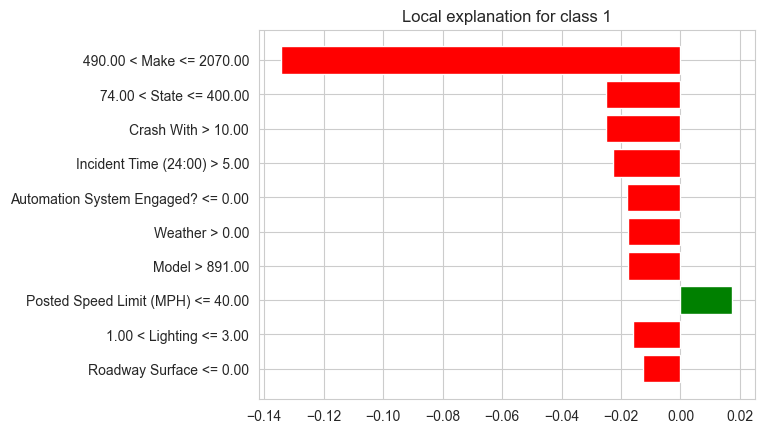

Saved LIME PNG to: lime_explanations/LIME_Random Forest_US_idx5.png


In [ ]:
lime_explain(results_store_us, prep_us, model_name='Random Forest', dataset_label='US', instance_idx=5)

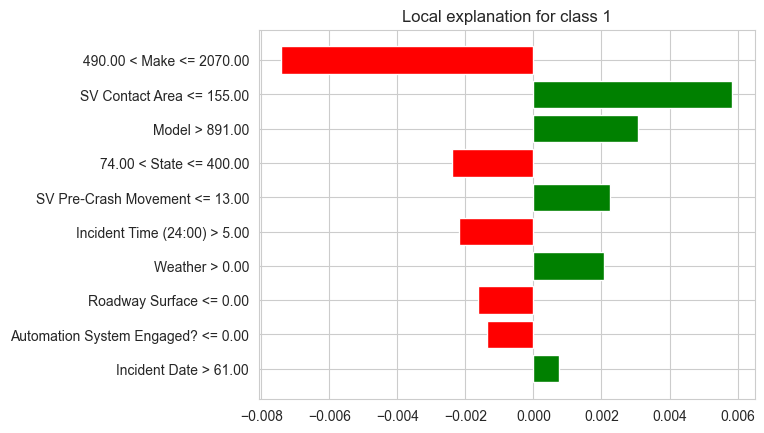

Saved LIME PNG to: lime_explanations/LIME_Logistic Regression_US_idx5.png


In [ ]:
lime_explain(results_store_us, prep_us, model_name='Logistic Regression', dataset_label='US', instance_idx=5)